## Dataanalys och visualisering för bank transaktioner

##### En omfattande genomgång av transaktionsdata med fokus på mönster, avvikelser och potentiell bedrägeridetektion med hjälp av pandas, seaborn och matplotlib

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Sätt sökvägar till CSV-filer
DATA_PATH = r"C:\Users\hanna\PycharmProjects\b_projekt\Data"
EXPORT_PATH = r"C:\Users\hanna\PycharmProjects\b_projekt\Exports"
DB_TABLES_PATH = r"C:\Users\hanna\PycharmProjects\b_projekt\DB_tables_data_export_to_csv_files"
REPORT_PATH = r"C:\Users\hanna\PycharmProjects\b_projekt\Reports\analyse_report.md"

files = {
    "accounts": os.path.join(DATA_PATH, "accounts.csv"),
    "transactions": os.path.join(DATA_PATH, "transactions.csv"),
    "pendingtransactions": os.path.join(DB_TABLES_PATH, "pending_transactions.csv"),
    "blacklist": os.path.join(EXPORT_PATH, "blacklist.csv")
}

# Läs in data
dataframes = {}
for name, path in files.items():
    if os.path.exists(path):  # Kontrollera att filen finns innan inläsning
        dataframes[name] = pd.read_csv(path)
        print(f"\n{name} - Filväg: {path}")
        print(f"Antal rader: {len(dataframes[name])}, Kolumner: {dataframes[name].columns.tolist()}")
        print(dataframes[name].head())
    else:
        print(f"Fil saknas: {path}")


accounts - Filväg: C:\Users\hanna\PycharmProjects\b_projekt\Data\accounts.csv
Antal rader: 1000, Kolumner: ['Personnummer', 'iban']
  Personnummer                      iban
0  400118-5901  SE8902EPWK73250364544965
1  400118-5901  SE8902IDSK51225196610969
2  391117-9285  SE8902OGIV86383792142837
3  391117-9285  SE8902QZEZ52320024971424
4  981215-7254  SE8902DWZI85436013187521

transactions - Filväg: C:\Users\hanna\PycharmProjects\b_projekt\Data\transactions.csv
Antal rader: 100000, Kolumner: ['transaction_id', 'timestamp', 'amount', 'currency', 'sender_account', 'receiver_account', 'sender_country', 'sender_municipality', 'receiver_country', 'receiver_municipality', 'transaction_type', 'notes']
                         transaction_id            timestamp    amount  \
0  62cacc89-95ca-41c0-a06f-d12950c85a37  2025-01-08 03:17:00   1174.47   
1  d1ae6818-9d0f-4e14-bc56-0165e8123ff0  2025-01-02 19:34:00  19068.02   
2  aa707bbc-7171-4a8f-bdd1-5a18943708d5  2025-01-12 20:08:00   7557.86   


In [21]:
# Fraud-detektion via z-score
transactions = dataframes.get("transactions")
if transactions is not None:
    transactions['zscore'] = zscore(transactions['amount'])
    fraudulent = transactions[transactions['zscore'].abs() > 3]
    print(f"Flaggade avvikande transaktioner (z-score > 3): {len(fraudulent)}")

Flaggade avvikande transaktioner (z-score > 3): 0


In [22]:
# Identifiera okända transaktioner baserat på IBAN från `accounts.csv`
accounts = dataframes.get("accounts")
if accounts is not None:
    known_accounts = set(accounts['iban'])

    okända_transaktioner = transactions[
        ~transactions['receiver_account'].isin(known_accounts) |
        ~transactions['sender_account'].isin(known_accounts)
    ]
    print(f"Totalt antal transaktioner med okända konton: {len(okända_transaktioner)}")

    skuggavsändare = transactions[~transactions['sender_account'].isin(known_accounts)]
    print(f"Transaktioner från okända avsändarkonton: {len(skuggavsändare)}")

    skuggtransaktioner = transactions[~transactions['receiver_account'].isin(known_accounts)]
    print(f"Transaktioner till okända mottagarkonton: {len(skuggtransaktioner)}")

Totalt antal transaktioner med okända konton: 90000
Transaktioner från okända avsändarkonton: 42597
Transaktioner till okända mottagarkonton: 47403


In [23]:
# Generera analysrapport och spara den
os.makedirs(os.path.dirname(REPORT_PATH), exist_ok=True)
with open(REPORT_PATH, "w", encoding='utf-8') as f:
    f.write("# Analysrapport\n\n")
    if transactions is not None:
        f.write(f"Flaggade avvikande transaktioner (z-score > 3): {len(fraudulent)}\n\n")
        f.write(f"Transaktioner till okända mål-konton: {len(skuggtransaktioner)}\n\n")
        f.write(f"Transaktioner från okända avsändarkonton: {len(skuggavsändare)}\n\n")
        f.write(f"Totalt antal transaktioner med okända konton: {len(okända_transaktioner)}\n\n")

        top_senders = transactions.groupby('sender_account')['amount'].sum().sort_values(ascending=False).head(10)
        f.write("Topp 10 avsändare efter total summa skickad:\n\n")
        f.write(top_senders.to_string() + "\n\n")

        frequent_targets = transactions['receiver_account'].value_counts().head(10)
        f.write("Topp 10 mottagarkonton:\n\n")
        f.write(frequent_targets.to_string() + "\n")

print(f"Analysrapporten har sparats i: {REPORT_PATH}")

Analysrapporten har sparats i: C:\Users\hanna\PycharmProjects\b_projekt\Reports\analyse_report.md


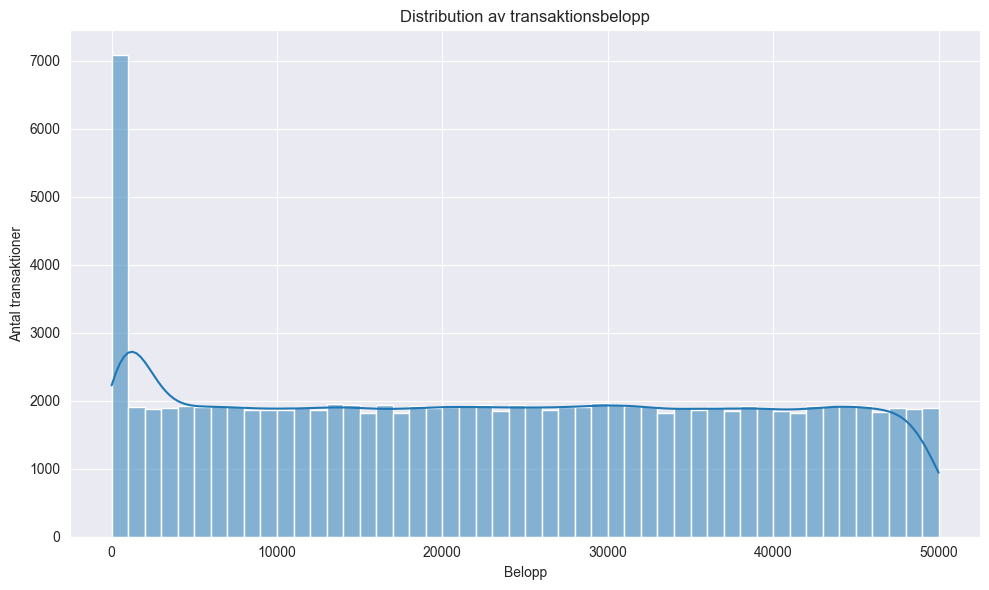

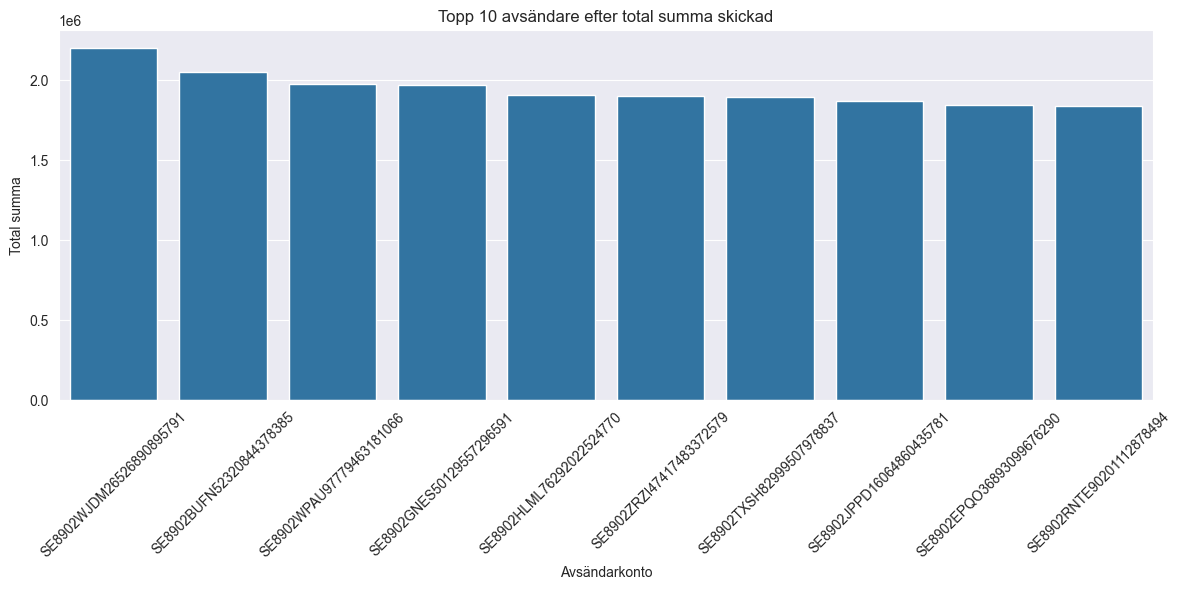

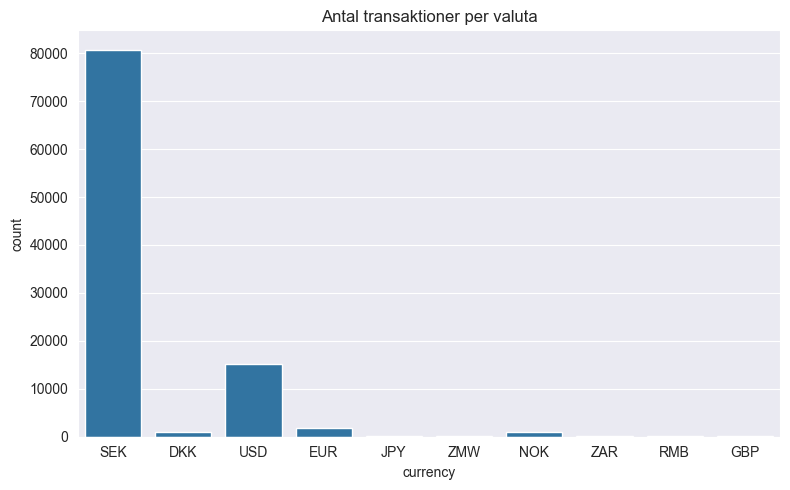

In [24]:
# Visualiseringar
plt.figure(figsize=(10, 6))
sns.histplot(transactions['amount'], bins=50, kde=True)
plt.title('Distribution av transaktionsbelopp')
plt.xlabel('Belopp')
plt.ylabel('Antal transaktioner')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_senders.index, y=top_senders.values)
plt.xticks(rotation=45)
plt.title('Topp 10 avsändare efter total summa skickad')
plt.ylabel('Total summa')
plt.xlabel('Avsändarkonto')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=transactions, x='currency')
plt.title('Antal transaktioner per valuta')
plt.tight_layout()
plt.show()

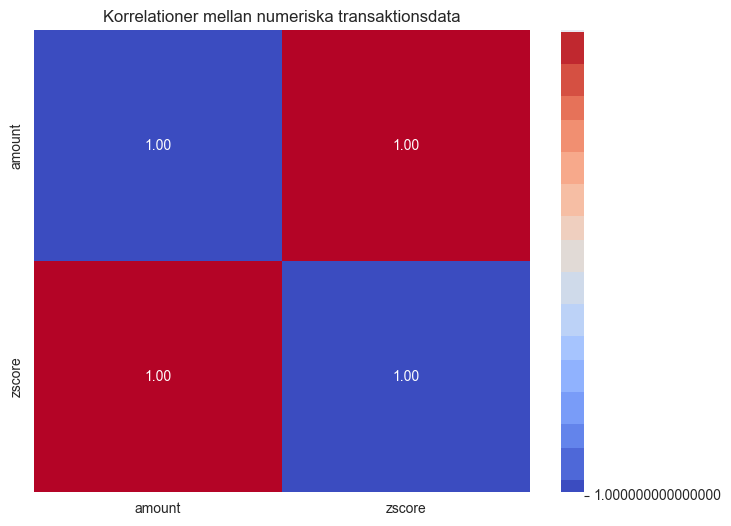

In [25]:
# Heatmap för korrelationer
plt.figure(figsize=(8, 6))
sns.heatmap(transactions.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelationer mellan numeriska transaktionsdata")
plt.show()

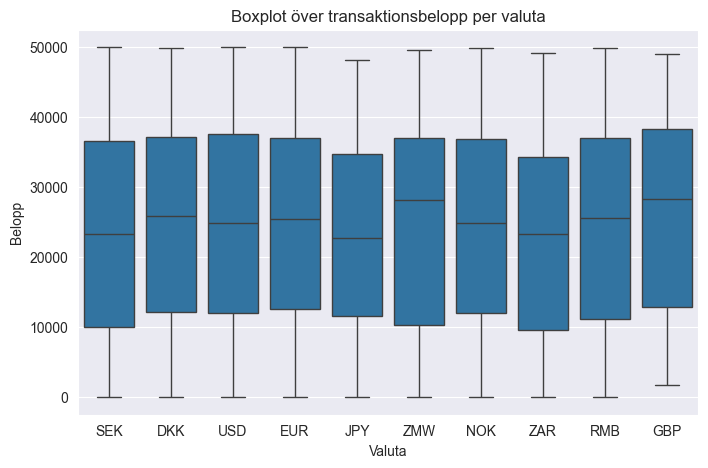

In [26]:
# Boxplot för att identifiera extrema transaktionsbelopp
plt.figure(figsize=(8, 5))
sns.boxplot(data=transactions, x="currency", y="amount")
plt.title("Boxplot över transaktionsbelopp per valuta")
plt.ylabel("Belopp")
plt.xlabel("Valuta")
plt.show()

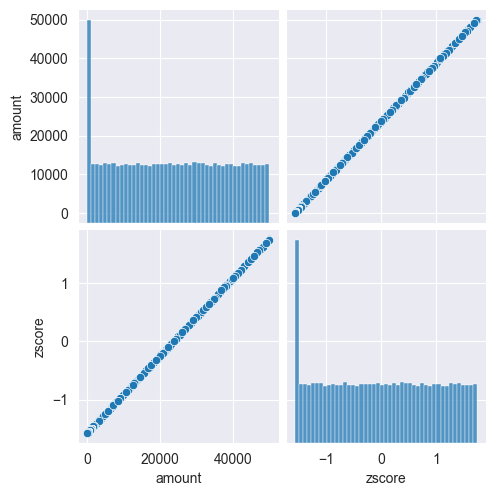

In [28]:
# Pairplot för att visa relationer mellan numeriska data
sns.pairplot(transactions[["amount", "zscore"]])
plt.show()